In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

# Configuration
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline

# Simulação com carga RL

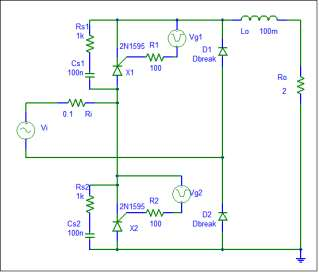

In [2]:
display(Image("cir1.png"))

Circuito em ngspice:

In [3]:
! cat netlist.cir

* NETLIST
vi vp vn dc 0 SIN(0 40 50)
ri vp n6 0.1

x1 n6 n4 n1 scr
r1 n4 n5 100
vg1 n5 n1 dc 0 PULSE(0 5 5m 1u 1u 200u 20m)
rs1 n3 n1 1k
cs1 n6 n3 100n

x2 0 n9 n6 scr
r2 n9 n10 100
vg2 n10 n6 dc 0 PULSE(0 5 15m 1u 1u 200u 20m)
rs2 n8 n6 1k
cs2 0 n8 100n

d1 vn n1 1n4002
d2 0 vn 1n4002

lo n1 n2 100m
ro n3 n2 2
vo 0 n3 DC 0


## Tensão e corrente de entrada e de saída

In [4]:
vin = np.genfromtxt('data/01-v_in.csv')
vout = np.genfromtxt('data/01-v_out.csv')
iin = np.genfromtxt('data/01-i_in.csv')
iout = np.genfromtxt('data/01-i_out.csv')

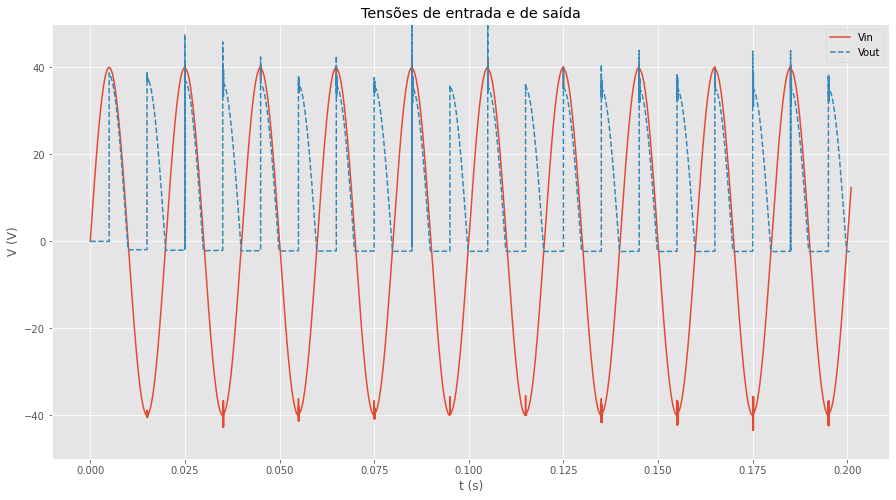

In [5]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(vin[:,0], vin[:,1])
ax1.plot(vout[:,0], vout[:,1], '--')
ax1.set_title("Tensões de entrada e de saída")
ax1.set_ylabel("V (V)")
ax1.set_xlabel("t (s)")
ax1.set_ylim([-50, 50])
ax1.legend(['Vin', 'Vout'])
plt.show()

No gráfico das tensões colocado acima, é possível perceber claramente que os tiristores disparam em 90 e -90 graus (ou seja, em 5s e 15s, em se considerando cada período de 20s). Além disso, é possível perceber que os tiristores desativam pouco tempo depois - mas não exatamente - do momento em que o sinal toca o zero, invertendo a direação das correntes.

Desta forma, a onda apresentada é formada pelos 50% finais de cada semiciclo, sendo que os semiciclos negativos estão refletidos para a parte positiva, a fim de retificar o sinal CA em sinal CC.

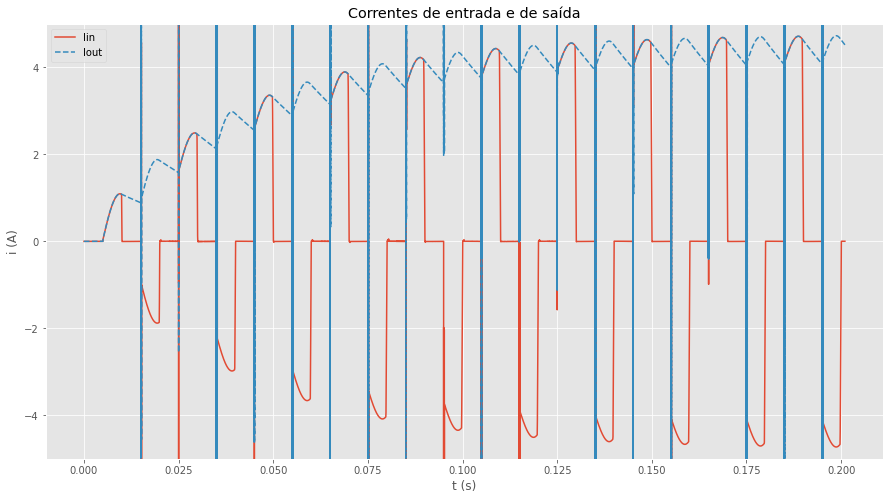

In [6]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(iin[:len(iin),0], iin[:,1], '-')
ax1.plot(iout[:len(iin),0], iout[:,1], '--')
ax1.set_title("Correntes de entrada e de saída")
ax1.set_ylabel("i (A)")
ax1.set_xlabel("t (s)")
ax1.set_ylim([-5, 5])
ax1.legend(['Iin', 'Iout'])
plt.show()

Ao analisar a corrente, percebemos dois comportamentos: o primeiro, diz respeito ao caráter transitório da corrente, por conta da indutância de saída. A corrente aumenta progressivamente até que o indutor se encontre suficientemente carregado, momento que podemos chamar de regime permanente do sistema. O segundo tem a ver com o mesmo chaveamento dos tiristores já comentado no gráfico anterior. Enquanto o tiristor está ativado, a corrente flui para carregar o indutor, quando o primeiro está desativado, a corrente começa a diminuir, mas logo que o próximo tiristor ativa, ela volta a subir.

As variações bruscas percebidas em ambas as figuras (outliers do gráfico) provavelmente se dão por conta de imprecisões nos modelos SPICE, em especial, o tiristor utilizado para a simulação é uma versão simplificada (como conversado previamente com o professor, que pode ser conferida aqui: http://paginapessoal.utfpr.edu.br/pfrimer/eletronica-de-potencia/modelo-de-simulacao-de-um-scr-para-o-ltspice/SCR.sub/view)

## Valores médios de saída

Infelizmente o software ngspice não possui a função `avgx`, então foi utilizada a função `avg` em todo o intervalo (0 a 200ms) como mostrado abaixo - por mais que seja sabido a diferença de precisão destes -, obtendo os seguintes resultados:

```
let vo = vr(n1)
let io = -i(vo)
meas tran vo_med avg vo
meas tran io_med avg io
```

$$
\bar{V_o} = 9.329 ~\text{V} \qquad
\bar{I_o} = 3.549 ~\text{A}
$$

Os valores teóricos podem ser calculados da seguinte maneira:

$$
\bar{V_o} = \frac{1}{\pi}\int_0^\pi V_o \cdot \sin \theta d\theta = \frac{V_p}{\pi} \cdot (1 + \cos \alpha) = \frac{40}{\pi}\cdot(1 + \cos (90))
$$

$$
\bar{V_o} = 12.732~\text{V}
$$

$$
\bar{I_o} = \frac{V_o}{Z_o}
$$

Considerando $Z_L = j\omega L = j \cdot 2\pi 50 \cdot 0.1$, temos:

$$
\bar{I_o} = \left|\frac{40}{2+j31.416}\right| = 1.2707 ~\text{A}
$$

Sobre as diferenças, é natural que o modelo teórico não englobre eventuais perdas que acarretariam em uma diminuição da tensão média e aumento da corrente de saída. O cálculo utilizando `avg` - e não `avgx` - também dificulta uma análise precisa, pois não considera uma média por ciclos.

## Fator de potência visto pela fonte

Calculo de P e S utilizando o ngspice:

```
let vin = vr(vp)-vr(vn)
meas tran vi_rms rms vin
meas tran ii_rms rms i(vi)

let p_v = vin*(-i(vi))
let s = vi_rms * ii_rms
meas tran p_med avg p_v
print s
let pf = p_med/s
print pf
```

Obtendo os seguintes resultados:

$$
Vi_{rms} = 28.16 ~\text{V} \quad Ii_{rms} = 3.977 ~\text{A} \quad P_{med} = 55.19 ~\text{W} \quad S = 111.99 ~\text{VA}
$$

Assim:

$$
\text{FP} = \frac{P_{med}}{S} = 0.4928
$$

O cálculo teórico do fator de potência é o seguinte:

$$
\text{FP} = \frac{\sqrt{2} \cdot (1 + \cos \alpha)}{\sqrt{\pi^2 - \alpha \pi}} = 0.6366
$$

Os valores são um pouco diferentes, provavelmente pelo calculo dos valores eficazes que não foram feitos utilizando a função `avgx`

## Análise utilizando transformada de Fourier

Do arquivo `.out` conseguimos as seguintes tabelas:

In [7]:
! sed '/^No. of Data Rows : 2742$/,\
/^vi_rms              =  2.81579e+01 from=  1.00035e-01 to=  2.01000e-01$\
/!d;//d' data/02.out

Fourier analysis for vin:
  No. Harmonics: 30, THD: 0.794388 %, Gridsize: 200, Interpolation Degree: 1

Harmonic Frequency   Magnitude   Phase       Norm. Mag   Norm. Phase
-------- ---------   ---------   -----       ---------   -----------
 0       0           0.0231164   0           0           0          
 1       50          39.6735     18.4137     1           0          
 2       100         0.0459982   -60.743     0.00115942  -79.156    
 3       150         0.128014    -67.306     0.00322668  -85.72     
 4       200         0.0458369   149.086     0.00115535  130.672    
 5       250         0.109384    -119.04     0.0027571   -137.46    
 6       300         0.0459858   -1.6649     0.00115911  -20.079    
 7       350         0.0661213   33.1736     0.00166664  14.7599    
 8       400         0.045667    -152.04     0.00115107  -170.46    
 9       450         0.076777    -49.886     0.00193522  -68.3      
 10      500         0.0457648   57.3064     0.00115354  38.8927    

Dela, tiramos uma defasagem de:

$$\phi = -23.264 - 18.4137 = -41.678 ~^o$$

No gráfico de tensão de entrada e corrente de entrada (abaixo) é possível observar que este valor deveria ser próximo de $-45 ~^o$:

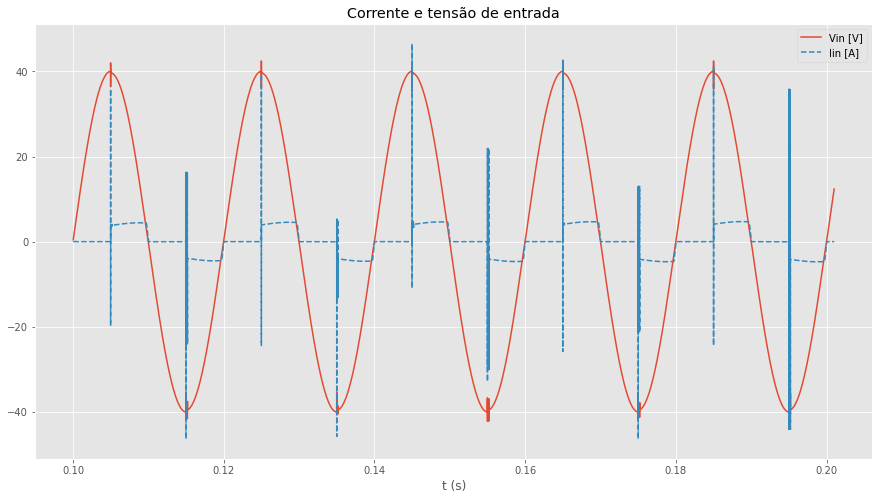

In [14]:
vin = np.genfromtxt('data/01-vi-perm.csv')
iin = np.genfromtxt('data/01-ii-perm.csv')

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(vin[:,0], vin[:,1], '-')
ax1.plot(iin[:,0], iin[:,1], '--')
ax1.set_title("Corrente e tensão de entrada")
ax1.set_xlabel("t (s)")
ax1.legend(['Vin [V]', 'Iin [A]'])
plt.show()

## Cálculo de rendimento do conversor

Podemos calcular o rendimento utilizando os valores calculados pelo spice (e que podem ser verificados na porção do arquivo `.out` mostrado acima), da seguinte forma:

$$
\eta = \frac{P_{out}}{P_{in}} = \frac{V_{out}\cdot I_{out}}{P_{in}} = \frac{9.329 \cdot 3.549}{55.19} = 0.6
$$

Uma eficiência de 60% é bastante baixa para circuitos elétricos, mesmo que não se espere uma eficiência muito próxima de 100% para um circuito retificador controlado por tiristores como o que está sendo analisado.

# Simulação com carga RLC (motor DC)

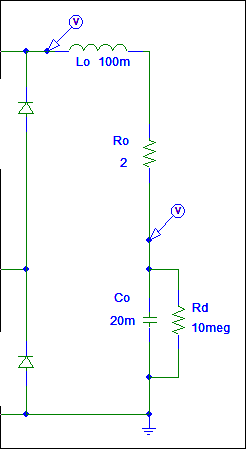

In [9]:
display(Image("cir2.png"))

Circuito em ngspice:

In [10]:
! cat netlist2.cir

* NETLIST
vi vp vn dc 0 SIN(0 40 50)
ri vp n6 0.1

x1 n6 n4 n1 scr
r1 n4 n5 100
vg1 n5 n1 dc 0 PULSE(0 5 2m 1u 1u 200u 20m)
rs1 n3 n1 1k
cs1 n6 n3 100n

x2 0 n9 n6 scr
r2 n9 n10 100
vg2 n10 n6 dc 0 PULSE(0 5 18m 1u 1u 200u 20m)
rs2 n8 n6 1k
cs2 0 n8 100n

d1 vn n1 1n4002
d2 0 vn 1n4002

lo n1 n2 100m
ro n3 n2 2
rd n4 n3 10meg
co nc n3 20m
vc nc n4 dc 0
vo 0 n4 DC 0


## Mudança do ângulo de disparo dos tiristores

Para que os tiristores disparem respectivamente em 36 e -36 graus (324 graus) de cada semiciclo, precisamos alterar o período dos pulsos na entrada G dos tiristores:

$$
t_1 = \frac{20\text{s} \cdot 36^o}{360^o} = 2\text{s} 
$$

$$
t_2 = \frac{20\text{s} \cdot 324^o}{360^o} = 18\text{s} 
$$

## Tensão e corrente de entrada e de saída

In [11]:
vin = np.genfromtxt('data/02-vi.csv')
vout = np.genfromtxt('data/02-vo.csv')
vco = np.genfromtxt('data/02-vco.csv')
iin = np.genfromtxt('data/02-ii.csv')
iout = np.genfromtxt('data/02-io.csv')

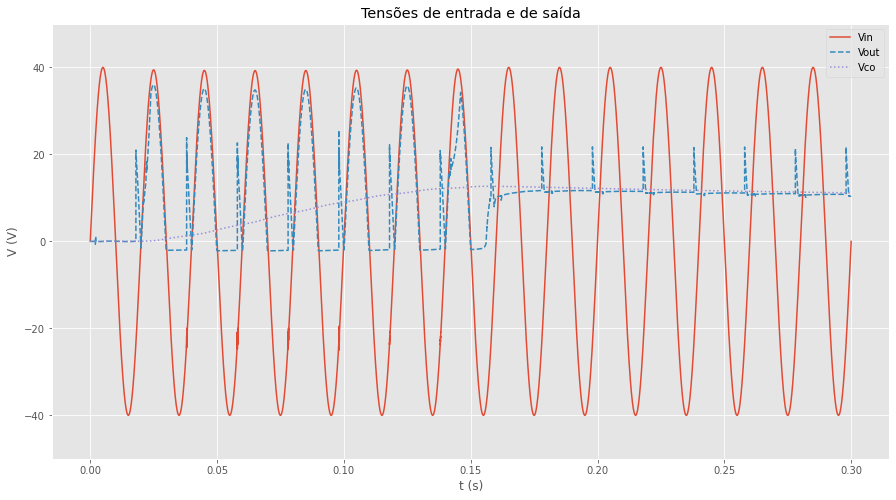

In [12]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(vin[:,0], vin[:,1])
ax1.plot(vout[:,0], vout[:,1], '--')
ax1.plot(vco[:,0], vco[:,1], ':')
ax1.set_title("Tensões de entrada e de saída")
ax1.set_ylabel("V (V)")
ax1.set_xlabel("t (s)")
ax1.set_ylim([-50, 50])
ax1.legend(['Vin', 'Vout', 'Vco'])
plt.show()

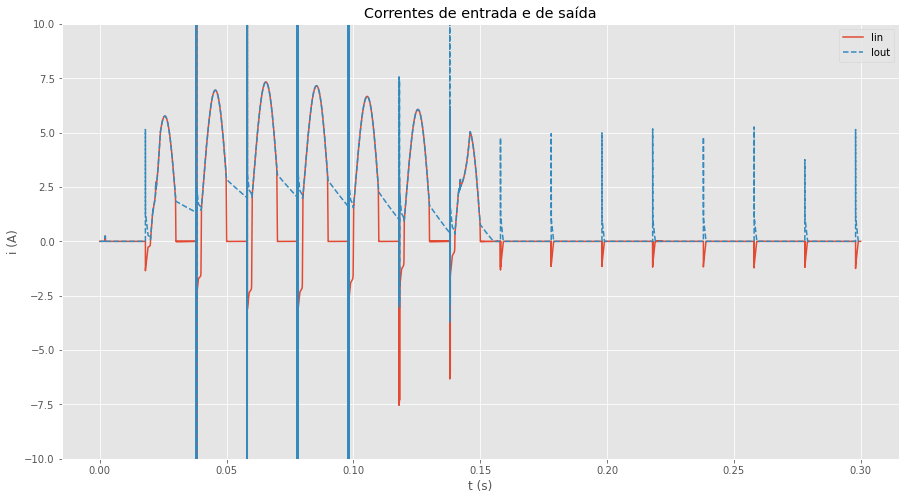

In [13]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(iin[:,0], iin[:,1], '-')
ax1.plot(iout[:,0], iout[:,1], '--')
ax1.set_title("Correntes de entrada e de saída")
ax1.set_ylabel("i (A)")
ax1.set_xlabel("t (s)")
ax1.set_ylim([-10, 10])
ax1.legend(['Iin', 'Iout'])
plt.show()

## Formas de onda no início da operação do conversor

As formas de onda no início estão coerentes com o esperado no processo de acionamento de um motor CC. Pelo gráfico de tensão é possível observar a tensão do capacitor que se eleva e representa a tensão advinda do aumento de velocidade do motor. Já no gráfico de corrente é possível perceber que, conforme a tensão do capacitor se eleva - ou seja, o motor aumenta a velocidade -, há uma diminuição da corrente drenada. 

Também é possível perceber os efeitos descritos no exercício anterior: quando o tiristor está desativado o valor da tensão de saída e da corrente de etrada são nulos, enquanto que a corrente de saída se mantém por conta do indutor na carga.

## Mudança a partir de 150ms

Perto de 150ms, a tensão no capacitor se eleva até um ponto em que não há uma diferença de tensão suficiente para que o tiristor dispare. Desta forma, a corrente de saída se anula (tiristores não disparam, não há corrente fluindo para a saída) e a tensão de saída se estabiliza na tensão provida pelo capacitor carregado.

# Anexos {-}

Arquivos utilizados e gerados para e na simulação:

In [17]:
%%bash
echo "ex1.cir"
echo "======="
echo ""
cat ex1.cir

ex1.cir

SCR controlled rectifier (input and ouput voltage/current)

* OPTIONS
.option TEMP=27C


* CONTROL
.control
tran 50u 201m uic

option numdgt=4
wrdata data/01-i_in.csv -i(vi)
wrdata data/01-v_in.csv vr(n6)-vr(vn)
wrdata data/01-i_out.csv -i(vo)
wrdata data/01-v_out.csv vr(n1)

let vo = vr(n1)
let io = -i(vo)
meas tran vo_med avg vo
meas tran io_med avg io

.endc

* END
.end


In [21]:
%%bash
echo "01.out"
echo "======="
echo ""
cat data/01.out

01.out


Circuit: scr controlled rectifier (input and ouput voltage/current)

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using transient initial conditions
Note: No ".plot", ".print", or ".fourier" lines; no simulations run

No. of Data Rows : 5666
vo_med              =  9.329006e+00 from=  0.000000e+00 to=  2.010000e-01
io_med              =  3.549419e+00 from=  0.000000e+00 to=  2.010000e-01


In [22]:
%%bash
echo "ex2.cir"
echo "======="
echo ""
cat ex2.cir

ex2.cir

SCR controlled rectifier (power factor and fourier analysis)

* OPTIONS
.option TEMP=27C


* CONTROL
.control
tran 50u 201m 100m

let vin = vr(n6)-vr(vn)

option nfreqs=30
fourier 50 vin
fourier 50 -i(vi)

set wr_vecname
option numdgt=4
wrdata data/01-four-vi.csv fourier11
wrdata data/01-four-ii.csv fourier21
wrdata data/01-vi-perm.csv vr(n6)-vr(vn)
wrdata data/01-ii-perm.csv -i(vi)

meas tran vi_rms rms vin
meas tran ii_rms rms i(vi)

let p_v = vin*(-i(vi))
let s = vi_rms * ii_rms
meas tran p_med avg p_v
print s
let pf = p_med/s
print pf

.endc

* END
.end


In [23]:
%%bash
echo "02.out"
echo "======="
echo ""
cat data/02.out

02.out


Circuit: scr controlled rectifier (power factor and fourier analysis)

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vp                                 2.33036e-12
vn                                 2.33036e-12
n6                                 2.33036e-12
x1.6                               2.56784e-20
x1.4                               9.71609e-13
x1.5                               1.40954e-23
n4                                 2.35383e-20
n1                                -5.20382e-24
n5                                -5.20382e-24
n3                                           0
x2.6                               2.33036e-12
x2.4                               1.34906e-12
x2.5                               2.33036e-12
n9                                 2.33036e-12
n10                                2.33036e-12
n8      

In [24]:
%%bash
echo "ex3.cir"
echo "======="
echo ""
cat ex3.cir

ex3.cir

SCR controlled rectifier (DC motor load)

* OPTIONS
.option TEMP=27C

* CONTROL
.control
tran 50u 300m uic

option numdgt=4
wrdata data/02-vi.csv vr(n6)-vr(vn)
wrdata data/02-ii.csv -i(vi)
wrdata data/02-vo.csv vr(n1)
wrdata data/02-io.csv -i(vo)
wrdata data/02-vco.csv vr(n3)

.endc

* END
.end


In [25]:
%%bash
echo "03.out"
echo "======="
echo ""
cat data/03.out

03.out


Circuit: scr controlled rectifier (dc motor load)

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using transient initial conditions
Note: No ".plot", ".print", or ".fourier" lines; no simulations run

No. of Data Rows : 7481
